In [1]:
from svgpathtools import svg2paths, Path, Line, CubicBezier, QuadraticBezier, Arc
import numpy as np
import csv
from collections import defaultdict
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def extract_points_from_path(path_segment, num_samples=100):
    if isinstance(path_segment, (Line, CubicBezier, QuadraticBezier, Arc)):
        return [path_segment.point(t) for t in np.linspace(0, 1, num_samples)]
    return []

In [3]:
svg_file = './data/problems/frag0.svg' 
paths, _ = svg2paths(svg_file)

all_points = []
for curve_index, path in enumerate(paths):
    for segment in path:
        points = extract_points_from_path(segment)
        all_points.extend([(curve_index, 0.0000, float(p.real), float(p.imag)) for p in points])

with open('out.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['index', 'constant', 'x', 'y'])
    for index, constant, x, y in all_points:
        writer.writerow([index, constant, np.float64(x), np.float64(y)])

In [4]:
curves = defaultdict(list)
with open('ans.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  
    for row in reader:
        try:
            curve_no = int(float(row[0])) 
            x = float(row[2])
            y = float(row[3])
            curves[curve_no].append((x, y))
        except ValueError as e:
            print(f"Skipping line due to error: {e}")

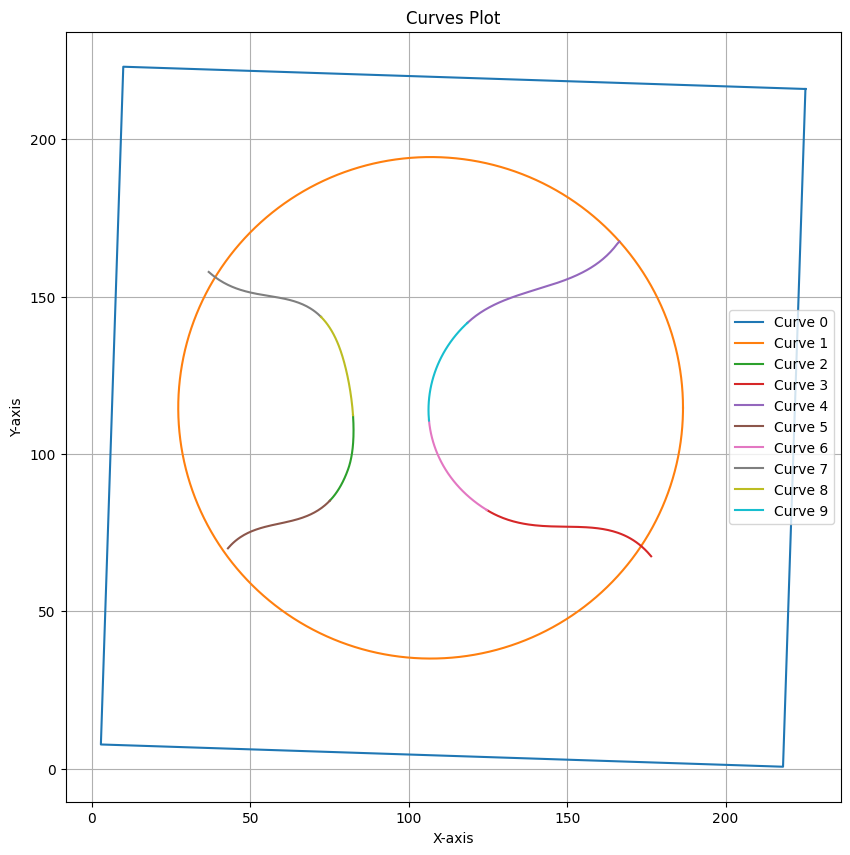

In [5]:
plt.figure(figsize=(10, 10))

for index, points in curves.items():
    x_values, y_values = zip(*points)  # Unpack the list of tuples into two lists: x_values and y_values
    plt.plot(x_values, y_values, label=f'Curve {index}')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Curves Plot')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
curves
print(len(curves))

10


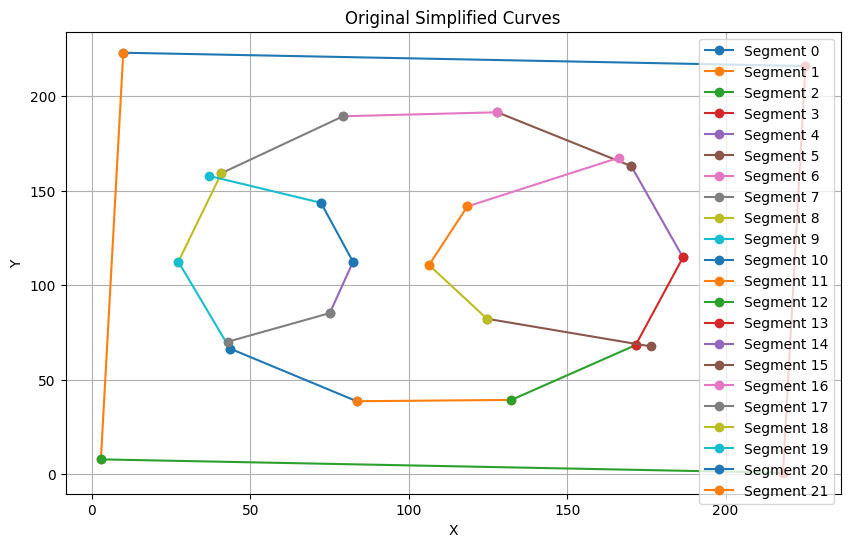

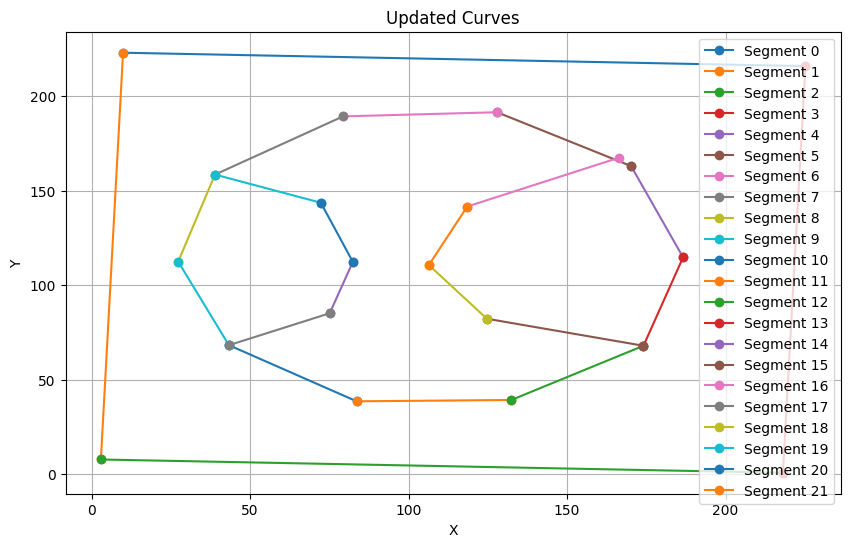

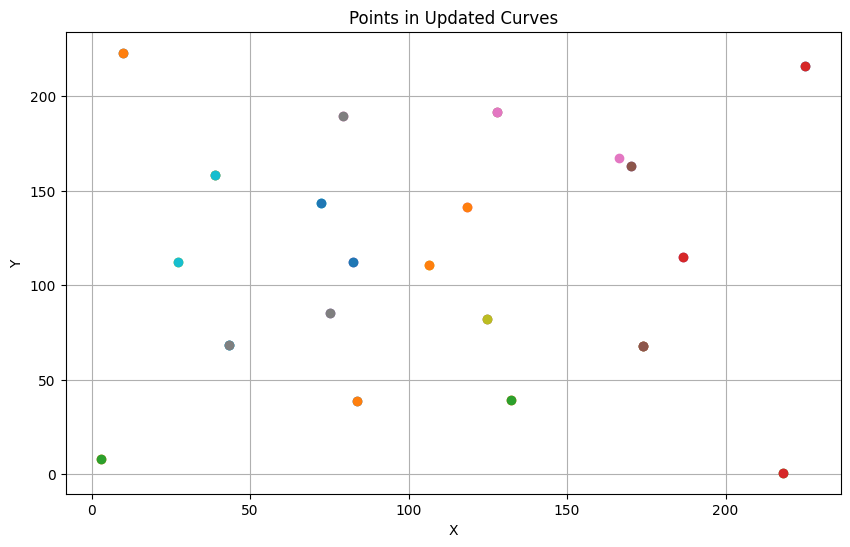

In [7]:
import math
import matplotlib.pyplot as plt

def point_line_distance(point, start, end):
    """Calculate the perpendicular distance from a point to a line."""
    if start == end:
        return math.dist(point, start)
    else:
        n = abs((end[1] - start[1]) * point[0] - (end[0] - start[0]) * point[1] + end[0] * start[1] - end[1] * start[0])
        d = math.sqrt((end[1] - start[1]) ** 2 + (end[0] - start[0]) ** 2)
        return n / d

def ramer_douglas_peucker(points, epsilon):
    """Simplify a curve with the Ramer-Douglas-Peucker algorithm."""
    dmax = 0.0
    index = 0
    end = len(points)
    for i in range(1, end - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    
    if dmax > epsilon:
        rec_results1, idx1 = ramer_douglas_peucker(points[:index+1], epsilon)
        rec_results2, idx2 = ramer_douglas_peucker(points[index:], epsilon)
        result = rec_results1[:-1] + rec_results2
        result_indices = idx1[:-1] + [i + index for i in idx2]
    else:
        result = [points[0], points[-1]]
        result_indices = [0, len(points) - 1]
    
    return result, result_indices

def simplify_curves(curves, epsilon):
    """Simplify all curves in a dictionary using the Ramer-Douglas-Peucker algorithm."""
    simplified_curves = {}
    inverse_dict = {}
    segment_points_dict = {}
    segment_id = 0
    
    for index, points in curves.items():
        simplified_points, indices = ramer_douglas_peucker(points, epsilon)
        
        for i in range(len(simplified_points) - 1):
            start_point = tuple(simplified_points[i])
            end_point = tuple(simplified_points[i + 1])
            line_key = (start_point, end_point)
            
            segment_indices = indices[i:i+2]
            segment_start_idx = segment_indices[0]
            segment_end_idx = segment_indices[1]
            
            simplified_curves[segment_id] = [start_point, end_point]
            inverse_dict[line_key] = segment_id
            segment_points_dict[segment_id] = points[segment_start_idx:segment_end_idx+1]
            
            segment_id += 1
    
    for key, points in simplified_curves.items():
        if key not in segment_points_dict:
            print(f"Warning: Segment {key} not found in segment_points_dict")
    
    return simplified_curves, inverse_dict, segment_points_dict

def distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def midpoint(point1, point2):
    """Calculate the midpoint between two points."""
    return ((point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2)

def round_point(point):
    """Round the coordinates of a point to one decimal place."""
    return (round(point[0], 1), round(point[1], 1))

def update_endpoints_with_midpoints(curves, inv, threshold=5.0):
    """Update endpoints with midpoints if they are very close to each other."""
    endpoints = {}
    updated_curves = {k: v[:] for k, v in curves.items()}
    inverse_dict = {}
    
    for key, points in curves.items():
        endpoints[key] = (points[0], points[-1])

    for key, (start, end) in endpoints.items():
        if distance(start, end) < threshold:
            mid = midpoint(start, end)
            updated_curves[key][0] = mid
            updated_curves[key][-1] = mid

    for key1, (start1, end1) in endpoints.items():
        for key2, (start2, end2) in endpoints.items():
            if key1 < key2:
                if distance(start1, start2) < threshold:
                    mid = midpoint(start1, start2)
                    updated_curves[key1][0] = mid
                    updated_curves[key2][0] = mid
                if distance(start1, end2) < threshold:
                    mid = midpoint(start1, end2)
                    updated_curves[key1][0] = mid
                    updated_curves[key2][-1] = mid
                if distance(end1, start2) < threshold:
                    mid = midpoint(end1, start2)
                    updated_curves[key1][-1] = mid
                    updated_curves[key2][0] = mid
                if distance(end1, end2) < threshold:
                    mid = midpoint(end1, end2)
                    updated_curves[key1][-1] = mid
                    updated_curves[key2][-1] = mid

    for key, points in updated_curves.items():
        updated_curves[key] = [round_point(point) for point in points]

    for index, points in updated_curves.items():
        for i in range(len(points) - 1):
            start_point = tuple(points[i])
            end_point = tuple(points[i + 1])
            line_key = (start_point, end_point)
            inverse_dict[line_key] = index

    return updated_curves, inverse_dict

def plot_segments(curves, inverse_dict, title):
    """Plot segments and points."""
    plt.figure(figsize=(10, 6))
    for (start, end), segment_id in inverse_dict.items():
        x = [start[0], end[0]]
        y = [start[1], end[1]]
        plt.plot(x, y, marker='o', label=f'Segment {segment_id}')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_points(curves, title):
    """Plot points."""
    plt.figure(figsize=(10, 6))
    for points in curves.values():
        x, y = zip(*points)
        plt.plot(x, y, marker='o', linestyle='None')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

epsilon = 5
simplified_curves, inv, curves = simplify_curves(curves, epsilon)

threshold = 5
updated_curves, inverse_dict = update_endpoints_with_midpoints(simplified_curves, inv, threshold)

plot_segments(simplified_curves, inv, "Original Simplified Curves")

plot_segments(updated_curves, inverse_dict, "Updated Curves")

plot_points(updated_curves, "Points in Updated Curves")


C:\Users\shubh\AppData\Local\Temp\ipykernel_1580\2530629310.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(curves))  # Use a colormap with enough distinct colors


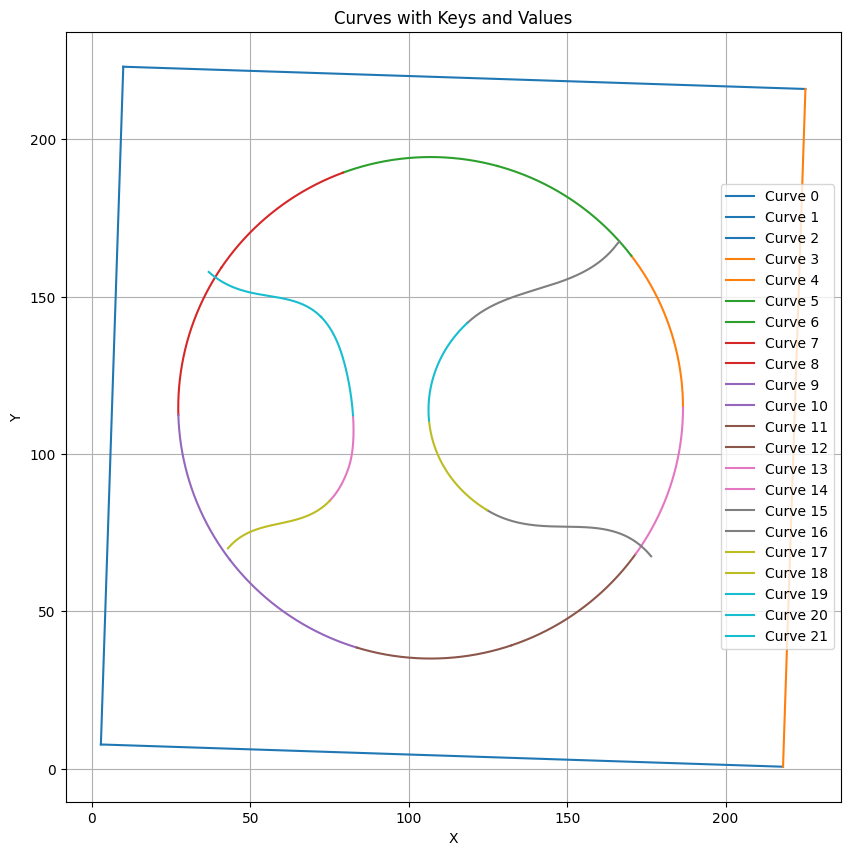

In [8]:
import matplotlib.pyplot as plt
import random

def plot_all_curves(curves, title):
    """Plot all curves with their keys and values."""
    plt.figure(figsize=(10, 10))
    colors = plt.cm.get_cmap('tab10', len(curves))  # Use a colormap with enough distinct colors

    for key, points in curves.items():
        x, y = zip(*points)
        plt.plot(x, y, linestyle='-', color=colors(key), label=f'Curve {key}')
        # for i, point in enumerate(points):
        #     plt.text(point[0], point[1], f'{key},{i}', fontsize=8)

    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example input
# curves = {
#     0: [(0, 0), (1, 2), (2, 3), (4, 4), (5, 5)],
#     1: [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]
# }

# Plot all curves
plot_all_curves(curves, "Curves with Keys and Values")


In [9]:
from collections import defaultdict

adj_list = defaultdict(list)

for polyline in updated_curves.values():
    for i in range(len(polyline) - 1):
        start, end = polyline[i], polyline[i+1]
        adj_list[start].append(end)
        adj_list[end].append(start)

adj_list = dict(adj_list)
# adj_list

In [10]:
from collections import defaultdict

def find_cycles(graph):
    def dfs(node, start, visited, path):
        visited[node] = True
        path.append(node)
        
        for neighbor in graph[node]:
            if neighbor == start and len(path) > 2:
                # Found a cycle
                cycle = path[:] + [start]
                cycles.append(cycle)
            elif not visited[neighbor]:
                dfs(neighbor, start, visited, path)
        
        path.pop()
        visited[node] = False

    cycles = []
    visited = defaultdict(bool)
    
    for node in graph:
        if not visited[node]:
            dfs(node, node, visited, [])
    
    # Remove duplicate cycles (cycles with the same set of nodes)
    unique_cycles = []
    for cycle in cycles:
        cycle_set = set(cycle)
        if all(cycle_set != set(c) for c in unique_cycles):
            unique_cycles.append(cycle)
    
    return unique_cycles

def separate_non_cycle_lines(segments, cycles):
    cycle_edges = set()
    for cycle in cycles:
        for i in range(len(cycle) - 1):
            edge = tuple(sorted([cycle[i], cycle[i + 1]]))
            cycle_edges.add(edge)
    
    non_cycle_lines = []
    for start, end in segments:
        edge = tuple(sorted([start, end]))
        if edge not in cycle_edges:
            non_cycle_lines.append((start, end))
    
    return non_cycle_lines

# Function to construct adjacency list from updated_curves
def construct_adj_list(updated_curves):
    adj_list = defaultdict(list)
    segments = []
    for polyline in updated_curves.values():
        for i in range(len(polyline) - 1):
            start, end = polyline[i], polyline[i + 1]
            adj_list[start].append(end)
            adj_list[end].append(start)
            segments.append((start, end))
    return adj_list, segments

adj_list, segments = construct_adj_list(updated_curves)

adj_list = dict(adj_list)

unique_cycles = find_cycles(adj_list)

non_cycle_lines = separate_non_cycle_lines(segments, unique_cycles)

print("Unique Cycles:")
for cycle in unique_cycles:
    print(cycle)

print("\nNon-Cycle Lines:")
for line in non_cycle_lines:
    print(line)


Unique Cycles:
[(225.2, 215.9), (9.9, 223.0), (2.9, 7.7), (218.1, 0.7), (225.2, 215.9)]
[(186.6, 114.7), (170.2, 163.0), (127.9, 191.5), (79.3, 189.3), (38.9, 158.5), (27.3, 112.4), (43.3, 68.2), (83.6, 38.5), (132.4, 39.2), (174.1, 67.9), (186.6, 114.7)]
[(186.6, 114.7), (170.2, 163.0), (127.9, 191.5), (79.3, 189.3), (38.9, 158.5), (72.3, 143.6), (82.4, 112.3), (75.1, 85.1), (43.3, 68.2), (83.6, 38.5), (132.4, 39.2), (174.1, 67.9), (186.6, 114.7)]
[(38.9, 158.5), (27.3, 112.4), (43.3, 68.2), (75.1, 85.1), (82.4, 112.3), (72.3, 143.6), (38.9, 158.5)]

Non-Cycle Lines:
((174.1, 67.9), (124.7, 82.2))
((118.5, 141.6), (166.5, 167.5))
((124.7, 82.2), (106.4, 110.6))
((106.4, 110.6), (118.5, 141.6))


In [11]:
def point_to_segment_dist(p, v, w):
    l2 = np.sum((v - w) ** 2)
    if l2 == 0:
        return np.sum((p - v) ** 2)
    t = max(0, min(1, np.dot(p - v, w - v) / l2))
    projection = v + t * (w - v)
    return np.sum((p - projection) ** 2)

def mean_square_fitting_error(polygon, square_vertices):
    total_error = 0
    for point in polygon:
        min_dist = float('inf')
        for i in range(len(square_vertices)):
            segment_start = square_vertices[i]
            segment_end = square_vertices[(i + 1) % len(square_vertices)]
            dist = point_to_segment_dist(point, segment_start, segment_end)
            if dist < min_dist:
                min_dist = dist
        total_error += min_dist
    mse = total_error / len(polygon)
    return mse


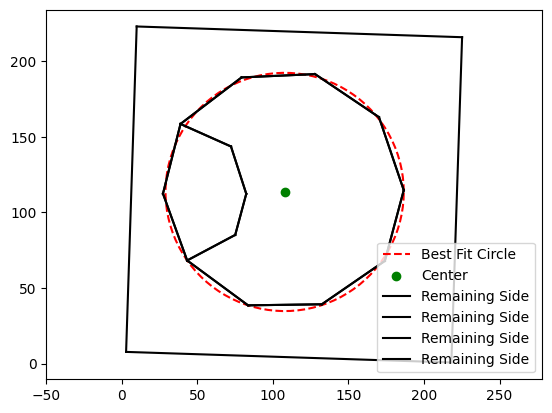

4.410201345666575
Mean Square Fitting Error: 4.4102


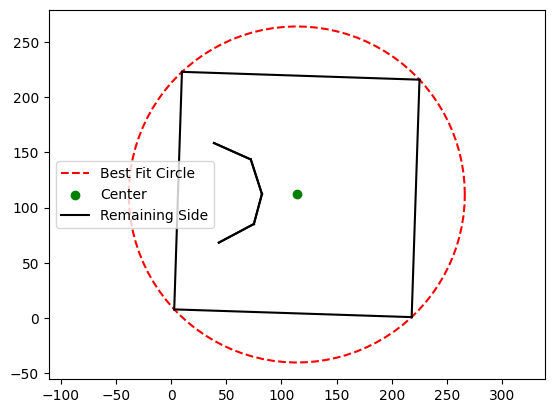

797.9050819853105


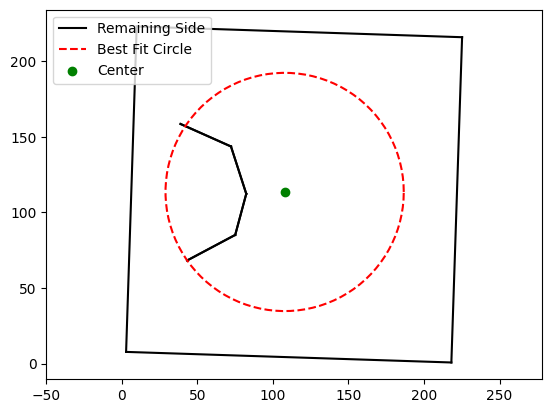

[[(225.2, 215.9), (9.9, 223.0), (2.9, 7.7), (218.1, 0.7), (225.2, 215.9)]]

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

remaining_sides = set()

def closest_point_on_circle(point, center, radius):
    direction = point - center
    direction /= np.linalg.norm(direction)
    return center + direction * radius

def sample_points_along_segment(p1, p2, num_points=100):
    return np.linspace(p1, p2, num_points)

def mean_square_circle_error(polygon, center, radius, num_points=100):
    total_error = 0
    total_samples = 0
    
    for i in range(len(polygon)):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % len(polygon)]
        
        segment_points = sample_points_along_segment(p1, p2, num_points)
        
        for point in segment_points:
            closest_point = closest_point_on_circle(point, center, radius)
            dist = np.linalg.norm(point - closest_point)
            error = dist ** 2
            total_error += error
        
        total_samples += len(segment_points)
    
    mse = total_error / total_samples
    return mse

def best_fit_circle(polygon):
    polygon = np.array(polygon)
    
    best_mse = float('inf')
    best_center = None
    best_radius = None
    
    for _ in range(100):  # Number of iterations
        sample_indices = np.random.choice(len(polygon), 3, replace=False)
        sample_points = polygon[sample_indices]
        
        A = sample_points[0]
        B = sample_points[1]
        C = sample_points[2]
        
        D = 2 * (A[0] * (B[1] - C[1]) + B[0] * (C[1] - A[1]) + C[0] * (A[1] - B[1]))
        if D == 0:
            continue
        
        Ux = ((A[0]**2 + A[1]**2) * (B[1] - C[1]) + (B[0]**2 + B[1]**2) * (C[1] - A[1]) + (C[0]**2 + C[1]**2) * (A[1] - B[1])) / D
        Uy = ((A[0]**2 + A[1]**2) * (C[0] - B[0]) + (B[0]**2 + B[1]**2) * (A[0] - C[0]) + (C[0]**2 + C[1]**2) * (B[0] - A[0])) / D
        center = np.array([Ux, Uy])
        radius = np.linalg.norm(center - A)
        
        mse = mean_square_circle_error(polygon, center, radius)
        if mse < best_mse:
            best_mse = mse
            best_center = center
            best_radius = radius
    
    return best_center, best_radius, best_mse

def plot_polygon_and_circle(polygon, center, radius, label):
    polygon = np.array(polygon)  # Ensure polygon is a numpy array
    theta = np.linspace(0, 2 * np.pi, 100)
    circle_x = center[0] + radius * np.cos(theta)
    circle_y = center[1] + radius * np.sin(theta)
    
    plt.plot(circle_x, circle_y, 'r--', label=label)
    plt.scatter(*center, color='green', zorder=5, label='Center')

def plot_remaining_sides(unique_cycles, marked_sides):
    for polygon in unique_cycles:
        polygon = np.array(polygon)
        for i in range(len(polygon)):
            side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
            if side not in marked_sides:
                plt.plot(*np.array([polygon[i], polygon[(i + 1) % len(polygon)]]).T, 'k-', label='Remaining Side' if i == 0 else "")
                

min_heap = []
possible_circles = []
unused_loops = []

for polygon in unique_cycles:
    center, radius, mse = best_fit_circle(polygon)
    heapq.heappush(min_heap, (mse, center, radius, polygon))

marked_sides = set()

while min_heap:
    mse, center, radius, polygon = heapq.heappop(min_heap)
    
    contains_marked_side = False
    for i in range(len(polygon)):
        side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
        if side in marked_sides:
            contains_marked_side = True
            break
    
    if contains_marked_side:
        unused_loops.append(polygon)
        continue
    
    plot_polygon_and_circle(polygon, center, radius, label='Best Fit Circle')
    plot_remaining_sides(unique_cycles, marked_sides)
    plt.legend()
    plt.axis('equal')
    plt.show()
    print(mse)
    if mse < 75:
        print(f'Mean Square Fitting Error: {mse:.4f}')
        possible_circles.append((center, radius, polygon))
        
        for i in range(len(polygon)):
            side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
            marked_sides.add(side)
    else:
        unused_loops.append(polygon)

filtered_unused_loops = []
for loop in unused_loops:
    all_sides_unused = True
    for i in range(len(loop)):
        side = tuple(sorted([tuple(loop[i]), tuple(loop[(i + 1) % len(loop)])]))
        if side in marked_sides:
            all_sides_unused = False
            break
    if all_sides_unused:
        filtered_unused_loops.append(loop)

plt.figure()

plot_remaining_sides(unique_cycles, marked_sides)
for polygon in unique_cycles:
    polygon = np.array(polygon)
    for i in range(len(polygon)):
        side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
        if side not in marked_sides:
            remaining_sides.add(side)
            
remaining_sides = set([
    ((float(x1), float(y1)), (float(x2), float(y2)))
    for ((x1, y1), (x2, y2)) in remaining_sides
])

for center, radius, polygon in possible_circles:
    plot_polygon_and_circle(polygon, center, radius, label='Best Fit Circle')

plt.legend()
plt.axis('equal')
plt.show()

filtered_unused_loops


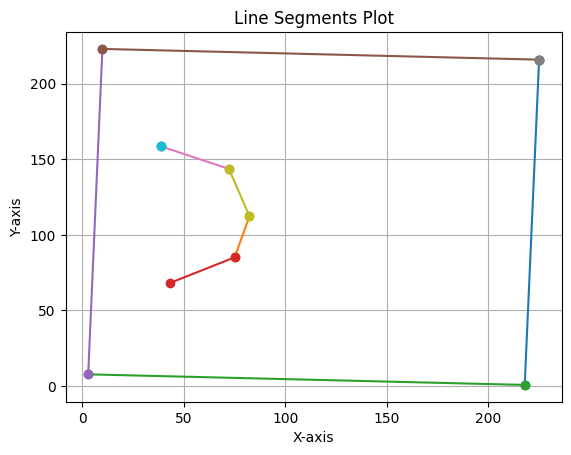

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define the line segments
line_segments = remaining_sides

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each line segment
for (x1, y1), (x2, y2) in line_segments:
    ax.plot([x1, x2], [y1, y2], marker='o')

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Line Segments Plot')

# Display the plot
plt.grid(True)
plt.show()


In [14]:

for polygon in unique_cycles:
    for i in range(len(polygon)):
        side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
        remaining_sides.add(side)

# Remove sides in possible_circles
for _, _, polygon in possible_circles:
    for i in range(len(polygon)):
        side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
        if side in remaining_sides:
            remaining_sides.remove(side)

# Remove sides in filtered_unused_loops
for polygon in filtered_unused_loops:
    for i in range(len(polygon)):
        side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
        if side in remaining_sides:
            remaining_sides.remove(side)

print(remaining_sides)

{((38.9, 158.5), (72.3, 143.6)), ((38.9, 158.5), (38.9, 158.5)), ((43.3, 68.2), (75.1, 85.1)), ((72.3, 143.6), (82.4, 112.3)), ((75.1, 85.1), (82.4, 112.3))}


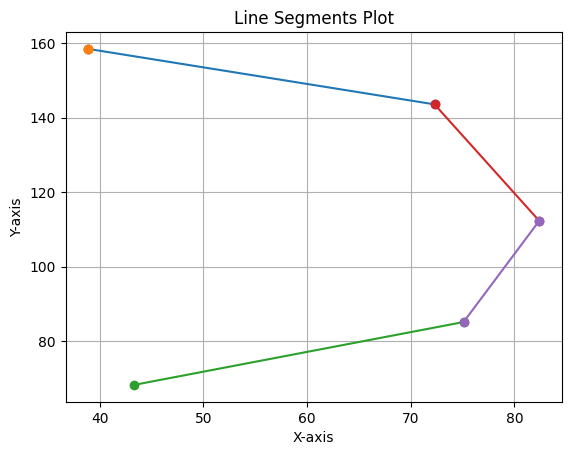

In [15]:
import matplotlib.pyplot as plt
import numpy as np

line_segments = remaining_sides

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each line segment
for (x1, y1), (x2, y2) in line_segments:
    ax.plot([x1, x2], [y1, y2], marker='o')

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Line Segments Plot')

# Display the plot
plt.grid(True)
plt.show()


{((np.float64(124.7), np.float64(82.2)), (np.float64(174.1), np.float64(67.9))): [((174.1, 67.9), (124.7, 82.2))], ((np.float64(118.5), np.float64(141.6)), (np.float64(166.5), np.float64(167.5))): [((118.5, 141.6), (166.5, 167.5))], ((np.float64(124.7), np.float64(82.2)), (np.float64(106.4), np.float64(110.6))): [((124.7, 82.2), (106.4, 110.6))], ((np.float64(106.4), np.float64(110.6)), (np.float64(118.5), np.float64(141.6))): [((106.4, 110.6), (118.5, 141.6))]}


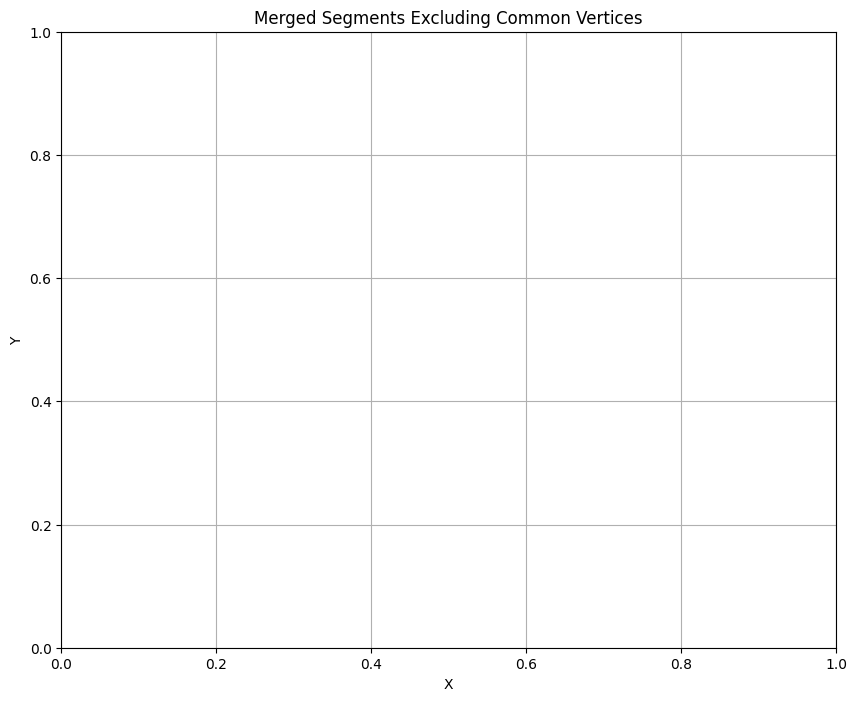

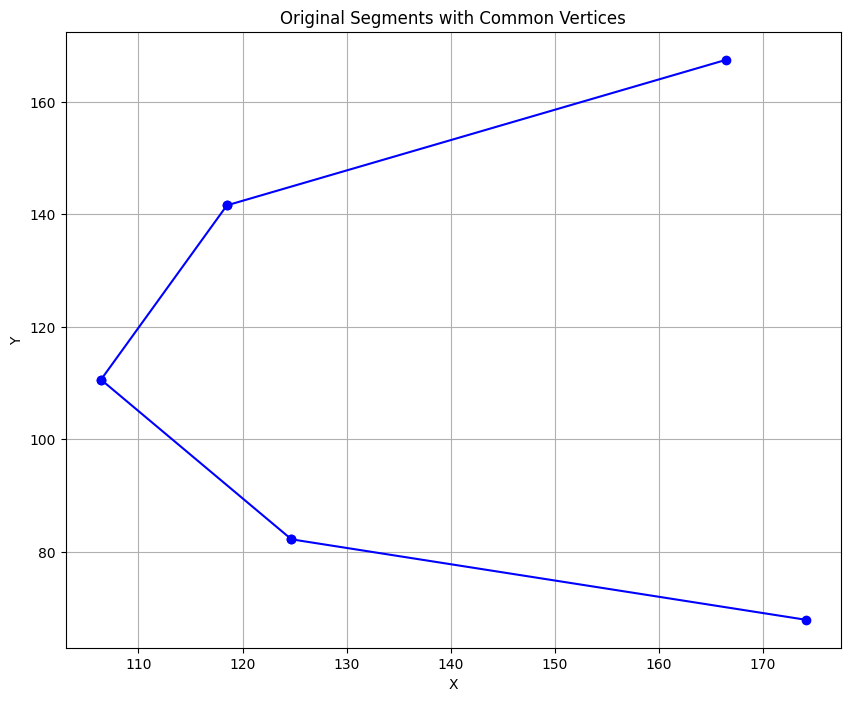

{((174.1, 67.9), (124.7, 82.2)), ((124.7, 82.2), (106.4, 110.6)), ((75.1, 85.1), (82.4, 112.3)), ((43.3, 68.2), (75.1, 85.1)), ((118.5, 141.6), (166.5, 167.5)), ((38.9, 158.5), (72.3, 143.6)), ((72.3, 143.6), (82.4, 112.3)), ((38.9, 158.5), (38.9, 158.5)), ((106.4, 110.6), (118.5, 141.6))}


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Function to check if two points are approximately equal
def are_approximately_equal(p1, p2, tol=5):
    return np.linalg.norm(np.array(p1) - np.array(p2)) < tol

# Function to compute the slope of a segment
def compute_slope(p1, p2):
    if p2[0] == p1[0]:
        return np.inf
    return (p2[1] - p1[1]) / (p2[0] - p1[0])

# Function to merge collinear segments
def merge_collinear_segments(segments, tol=1):
    merged_segments = []
    used = set()
    map = {}
    while len(used) < len(segments):
        # Find the first unused segment
        for i, (start1, end1) in enumerate(segments):
            if i not in used:
                break

        collinear_group = [(start1, end1)]
        used.add(i)

        while True:
            merged = False
            for j, (start2, end2) in enumerate(segments):
                if j in used:
                    continue
                
                # Check if the segments have the same slope and a common vertex with any in the collinear group
                if (np.abs(compute_slope(start1, end1) - compute_slope(start2, end2)) < tol):
                    if any(are_approximately_equal(start, start2) or 
                           are_approximately_equal(start, end2) or
                           are_approximately_equal(end, start2) or 
                           are_approximately_equal(end, end2) for start, end in collinear_group):
                        collinear_group.append((start2, end2))
                        used.add(j)
                        merged = True

            if not merged:
                break

        # Merge all collinear segments in the group
        all_points = np.array([point for segment in collinear_group for point in segment])
        min_idx = np.argmin(all_points[:, 0])
        max_idx = np.argmax(all_points[:, 0])
        min_y_idx = np.argmin(all_points[:, 1])
        max_y_idx = np.argmax(all_points[:, 1])

        # Depending on the slope, take min and max points differently
        # map[(tuple(all_points[min_idx]), tuple(all_points[max_idx]))] = collinear_group
        if np.abs(compute_slope(start1, end1)) < tol:  # Horizontal line
            merged_segments.append((tuple(all_points[min_idx]), tuple(all_points[max_idx])))
            map[(tuple(all_points[min_idx]), tuple(all_points[max_idx]))] = collinear_group
        else:  # General case
            map[(tuple(all_points[min_y_idx]), tuple(all_points[max_y_idx]))] = collinear_group
            merged_segments.append((tuple(all_points[min_y_idx]), tuple(all_points[max_y_idx])))

    return merged_segments, map

# Function to find segments with common vertices
def find_segments_with_common_vertices(segments, tol=1):
    common_vertex_segments = []
    for i, (start1, end1) in enumerate(segments):
        for j, (start2, end2) in enumerate(segments):
            if i != j:
                if are_approximately_equal(start1, start2, tol) or are_approximately_equal(start1, end2, tol) or \
                   are_approximately_equal(end1, start2, tol) or are_approximately_equal(end1, end2, tol):
                    common_vertex_segments.append((start1, end1))
                    break
    return common_vertex_segments

# Function to revert to all original segments with common vertices
def revert_to_original_segments(common_vertex_segments, original_segments, map):
    reverted_segments = []
    print(map)
    for it in common_vertex_segments:
        reverted_segments += map[it]
    return reverted_segments
    

# Function to plot segments
def plot_segments(segments, title, highlight_segments=None):
    plt.figure(figsize=(10, 8))
    for (start, end) in segments:
        plt.plot([start[0], end[0]], [start[1], end[1]], marker='o', color='blue')
    if highlight_segments:
        for (start, end) in highlight_segments:
            plt.plot([start[0], end[0]], [start[1], end[1]], marker='o', color='red')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()


segments = list(non_cycle_lines)

merged_segments, map = merge_collinear_segments(segments)

# Find segments with common vertices
common_vertex_segments = find_segments_with_common_vertices(merged_segments)

rem = revert_to_original_segments(common_vertex_segments, segments, map)
filtered_merged_segments = [seg for seg in merged_segments if seg not in common_vertex_segments]
# print(filtered_merged_segments)
# plot_segments(segments, "Original Segments")
plot_segments(filtered_merged_segments, "Merged Segments Excluding Common Vertices")
plot_segments(rem, "Original Segments with Common Vertices")
remaining_sides = remaining_sides.union(set(rem))
print(remaining_sides)

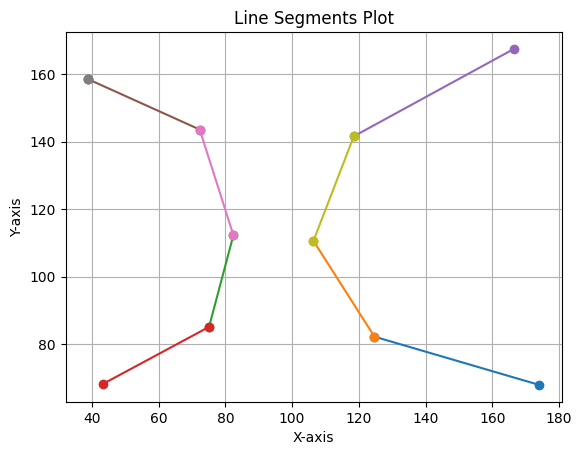

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define the line segments
line_segments = remaining_sides

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each line segment
for (x1, y1), (x2, y2) in line_segments:
    ax.plot([x1, x2], [y1, y2], marker='o')

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Line Segments Plot')

# Display the plot
plt.grid(True)
plt.show()


In [18]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Function to calculate the angle between a point and the centroid
# def calculate_angle(point, centroid):
#     return np.arctan2(point[1] - centroid[1], point[0] - centroid[0])

# # Function to check if the polygon is star-shaped
# def is_star_shape(vertices, tolerance=0.2):
#     # Calculate the centroid of the polygon
#     centroid = np.mean(vertices, axis=0)
    
#     # Calculate the angles and distances of vertices from the centroid
#     angles = [calculate_angle(vertex, centroid) for vertex in vertices]
#     distances = [np.linalg.norm(vertex - centroid) for vertex in vertices]
    
#     # Sort vertices by angle
#     sorted_vertices = sorted(zip(angles, distances, vertices))
    
#     # Extract sorted distances
#     sorted_distances = [dist for _, dist, _ in sorted_vertices]
    
#     # Check for alternating peaks and valleys
#     peaks = 0
#     valleys = 0
#     for i in range(1, len(sorted_distances) - 1):
#         if sorted_distances[i] > sorted_distances[i - 1] and sorted_distances[i] > sorted_distances[i + 1]:
#             peaks += 1
#         elif sorted_distances[i] < sorted_distances[i - 1] and sorted_distances[i] < sorted_distances[i + 1]:
#             valleys += 1
    
#     # Approximate check: a star shape should have several peaks and valleys
#     return peaks > 1 and valleys > 1

# # Function to process polygons and detect star shapes
# def detect_star_shapes(polygons):
#     star_shapes = []
#     non_star_shapes = []

#     for polygon in polygons:
#         vertices = np.array(polygon)
#         if is_star_shape(vertices):
#             star_shapes.append(vertices)
#         else:
#             non_star_shapes.append(vertices)

#     return star_shapes, non_star_shapes

# # Example polygons
# # filtered_unused_loops = [
# #     [(0, 0), (2, 5), (5, 2), (0, 5), (2, 0)],  # Random polygon
# #     [(0, 0), (1, 3), (3, 1), (3, -1), (1, -3), (-1, -3), (-3, -1), (-3, 1), (-1, 3)],  # Star-shaped polygon
# #     [(0, 0), (2, 6), (4, 0), (2, -6)],  # Non-star polygon
# # ]

# star_shapes, non_star_shapes = detect_star_shapes(filtered_unused_loops)

# # Plot the polygons
# plt.figure(figsize=(10, 10))
# for vertices in star_shapes:
#     if len(vertices) > 0:
#         plt.plot(vertices[:, 0], vertices[:, 1], 'o-', label='Star Shape')

# for vertices in non_star_shapes:
#     if len(vertices) > 0:
#         plt.plot(vertices[:, 0], vertices[:, 1], 'x-', label='Non-Star Shape')

# # Plot the original points for reference
# for points in filtered_unused_loops:
#     plt.plot([p[0] for p in points], [p[1] for p in points], 'x--', label='Original Points')

# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Detected Star Shapes')
# plt.legend()
# plt.grid(True)
# plt.show()


[array([[  9.9, 223. ],
       [  2.9,   7.7],
       [218.1,   0.7],
       [225.2, 215.9]])] [[((225.2, 215.9), (9.9, 223.0)), ((9.9, 223.0), (2.9, 7.7)), ((2.9, 7.7), (218.1, 0.7)), ((218.1, 0.7), (225.2, 215.9))]]


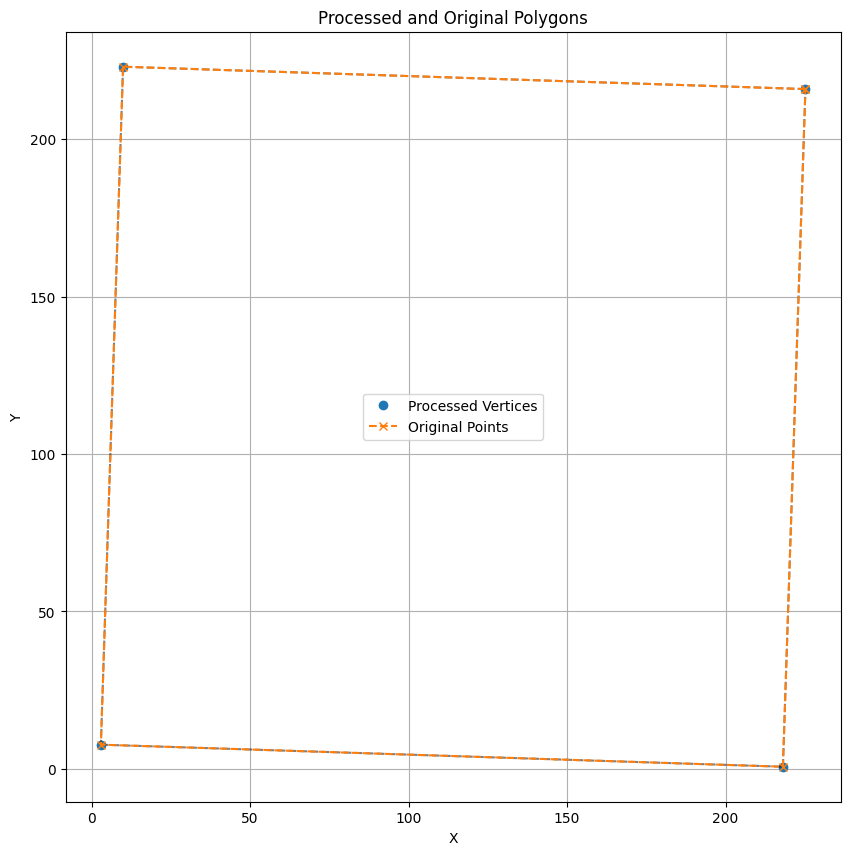

In [19]:
import math
import heapq
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate the angle between two lines
def calculate_angle(line1, line2):
    def vector_from_line(line):
        (x1, y1), (x2, y2) = line
        return (x2 - x1, y2 - y1)

    (x1, y1), (x2, y2) = line1
    (x3, y3), (x4, y4) = line2
    
    common_points = set(line1) & set(line2)
    if len(common_points) == 0:
        return None  

    vec1 = vector_from_line(line1)
    vec2 = vector_from_line(line2)
    
    magnitude1 = math.sqrt(vec1[0]**2 + vec1[1]**2)
    magnitude2 = math.sqrt(vec2[0]**2 + vec2[1]**2)
    
    if magnitude1 == 0 or magnitude2 == 0:
        return None 
    
    dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]
    cos_theta = dot_product / (magnitude1 * magnitude2)
    
    cos_theta = min(1, max(-1, cos_theta))
    
    angle = math.degrees(math.acos(cos_theta))
    return angle

def are_points_close(p1, p2, tolerance=5):
    return np.linalg.norm(np.array(p1) - np.array(p2)) < tolerance

def process_polygons(polygons):
    vertices_arr = []
    lines_arr = []

    for points in polygons:
        lines = []
        for i in range(len(points) - 1):
            lines.append((points[i], points[(i + 1) % len(points)]))

        heap = []
        for i in range(len(lines)):
            angle = calculate_angle(lines[i], lines[(i + 1) % len(lines)])
            if angle is not None:
                heapq.heappush(heap, (abs(90 - angle), lines[i], lines[(i + 1) % len(lines)]))

        vertices = set()
        while heap:
            angle_diff, line1, line2 = heapq.heappop(heap)
            if angle_diff < 360 / (len(vertices) + 1):
                common_point = tuple(set(line1) & set(line2))
                if common_point:
                    if not any(are_points_close(common_point, v) for v in vertices):
                        vertices.add(common_point)

        vertices = np.array(list(vertices))
        if vertices.ndim > 2:
            vertices = vertices.reshape(-1, 2)
        
        vertices_arr.append(vertices)
        lines_arr.append(lines)
    
    return vertices_arr, lines_arr

vertices_arr, lines_arr = process_polygons(filtered_unused_loops)
print(vertices_arr, lines_arr)

# Plot the polygons
plt.figure(figsize=(10, 10))
for vertices in vertices_arr:
    if len(vertices) > 0:  # Check if vertices is not empty
        plt.plot(vertices[:, 0], vertices[:, 1], 'o', label='Processed Vertices')

for lines in lines_arr:
    for line in lines:
        x_values, y_values = zip(*line)
        plt.plot(x_values, y_values, 'k--', alpha=0.5)

# Plot the original points for reference
for points in filtered_unused_loops:
    plt.plot([p[0] for p in points], [p[1] for p in points], 'x--',  label='Original Points')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Processed and Original Polygons')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
import numpy as np

def calculate_angle(point, centroid):
    return np.arctan2(point[1] - centroid[1], point[0] - centroid[0])

temp = []
for vertices in vertices_arr:
    centroid = np.mean(vertices, axis=0)
    vertices = np.array(vertices, dtype=float)
    
    angles = [calculate_angle(point, centroid) for point in vertices]
    sorted_vertices = [point for _, point in sorted(zip(angles, vertices), reverse=True)]
    
    temp.append(np.array(sorted_vertices))

vertices_arr = temp

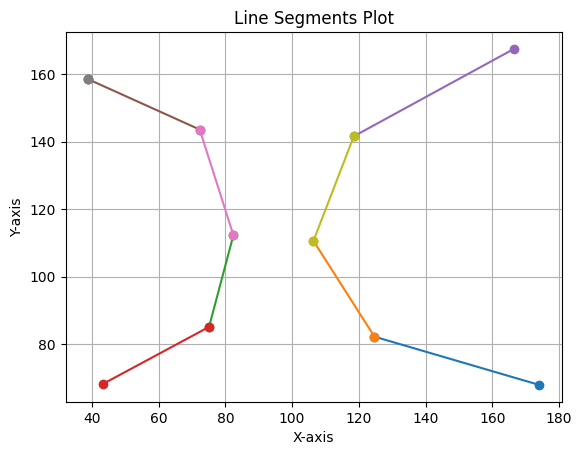

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define the line segments
line_segments = remaining_sides

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each line segment
for (x1, y1), (x2, y2) in line_segments:
    ax.plot([x1, x2], [y1, y2], marker='o')

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Line Segments Plot')

# Display the plot
plt.grid(True)
plt.show()


519.1059372979055
509.05904600490607
498.9336100275671
488.73347674224533
478.46033515543087
468.11869034659685
457.7153469617569
447.2442032480044
436.71817018170276
426.1393865646389
415.50160212134983
404.8157621589837
394.0845289733818
383.31013508893955
372.49483598318375
361.6375234149506
350.7432892976735
339.8157369220637
328.8571974105638
317.87002727576595
306.85661059070554
295.8193618217687
284.76072944575947
273.6832005047326
262.58930629615344
251.48162945718764
240.3628127889301
229.23557029265774
218.10270107801915
206.9671070903621
195.83181605802676
184.69764581143409
173.56853676441673
162.44964116128307
151.34496120932405
140.2589671118651
129.1968090526683
118.16469548156888
107.17064458310097
96.22620378800923
85.346662842277
74.58140676920821
64.11557574140069
56.63778930394765
64.02890726367339
74.48982786938669
85.25374510281017
96.13227849744317
107.07627317307046
118.07000104048916
129.10187074148516
140.1638430073296
151.24969758296683
162.3542768963447
173.

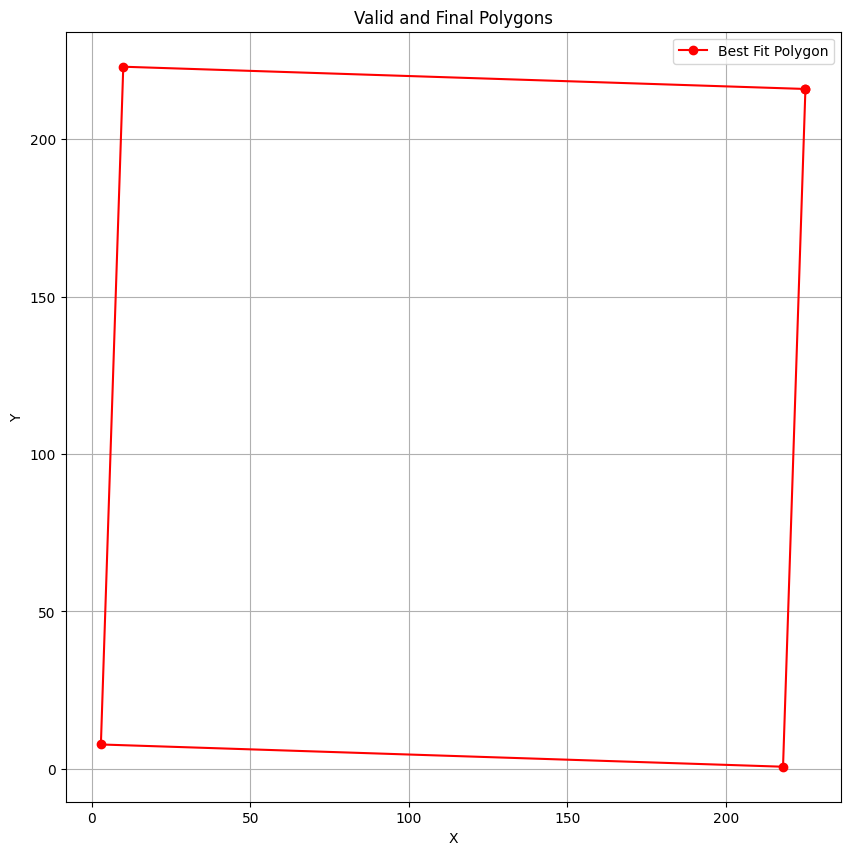

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import heapq

def get_best_fit_polygon(vertices, lines):
    centroid = np.mean(vertices, axis=0)
    distances = np.linalg.norm(vertices - centroid, axis=1)
    average_radius = np.mean(distances)
    n_vertices = len(vertices)

    def generate_regular_polygon(centroid, radius, n_vertices, rotation_angle=0):
        angles = np.linspace(0, 2 * np.pi, n_vertices, endpoint=False) + rotation_angle
        return np.array([
            [centroid[0] + radius * np.cos(angle), centroid[1] + radius * np.sin(angle)]
            for angle in angles
        ])

    def fit_score(vertices, approx_vertices):
        return np.sum(cdist(vertices, approx_vertices, 'euclidean').min(axis=1))

    def sample_points_along_segment(p1, p2, num_points=100):
        return np.linspace(p1, p2, num_points)

    def line_fit_score(lines, approx_vertices):
        total_distance = 0
        total_samples = 0
        
        for line in lines:
            p1, p2 = line
            segment_points = sample_points_along_segment(p1, p2)
            distances = cdist(segment_points, approx_vertices, 'euclidean').min(axis=1)
            total_distance += np.sum(distances)
            total_samples += len(distances)
        
        return total_distance / total_samples

    best_fit_polygon = None
    best_fit_score = float('inf')
    best_rotation_angle = 0
    best_radius = average_radius

    radii = np.linspace(average_radius - 1, average_radius + 1, 50)
    for radius in radii:
        for angle in np.linspace(0, 2 * np.pi, 360):
            approx_vertices = generate_regular_polygon(centroid, radius, n_vertices, rotation_angle=angle)
            vertex_score = fit_score(vertices, approx_vertices)
            line_score = line_fit_score(lines, approx_vertices)
            score = vertex_score + line_score
            if score < best_fit_score:
                best_fit_score = score
                best_fit_polygon = approx_vertices
                best_rotation_angle = angle
                best_radius = radius
            print(score)

    return best_fit_polygon, best_rotation_angle, best_radius

def process_polygons(vertices_list, lines_list, error_threshold=150):
    valid_polygons = []
    rejected_polygons = []
    remaining_segments = []

    for vertices, lines in zip(vertices_list, lines_list):
        if len(vertices) == 0 or len(lines) == 0:
            continue
            
        best_fit_polygon, best_rotation_angle, best_radius = get_best_fit_polygon(vertices, lines)

        line_errors = []
        for line in lines:
            p1, p2 = line
            segment_points = sample_points_along_segment(p1, p2)
            distances = cdist(segment_points, best_fit_polygon, 'euclidean').min(axis=1)
            line_errors.append(np.mean(distances))
        
        if any(error > error_threshold for error in line_errors):
            rejected_polygons.append((vertices, lines))
            for line in lines:
                remaining_segments.append(line)
            continue
        
        valid_polygons.append((best_fit_polygon, best_rotation_angle, best_radius))

    return valid_polygons, rejected_polygons, remaining_segments

def handle_remaining_segments(remaining_segments, error_threshold=150):
    heapq.heapify(remaining_segments)
    final_polygons = []
    utilized_segments = set()

    while remaining_segments:
        current_segment = heapq.heappop(remaining_segments)
        if any(tuple(map(tuple, segment)) in utilized_segments for segment in current_segment):
            continue

        remaining_polygons = [segment for segment in current_segment if tuple(map(tuple, segment)) not in utilized_segments]

        if len(remaining_polygons) == 0:
            continue

        vertices = np.array([point for segment in remaining_polygons for point in segment])
        lines = remaining_polygons
        best_fit_polygon, best_rotation_angle, best_radius = get_best_fit_polygon(vertices, lines)

        line_errors = []
        for line in lines:
            p1, p2 = line
            segment_points = sample_points_along_segment(p1, p2)
            distances = cdist(segment_points, best_fit_polygon, 'euclidean').min(axis=1)
            line_errors.append(np.mean(distances))

        print(line_errors)
        if any(error > error_threshold for error in line_errors):
            for line in lines:
                remaining_segments.append(line)
            continue

        final_polygons.append((best_fit_polygon, best_rotation_angle, best_radius))
        for segment in lines:
            utilized_segments.add(tuple(map(tuple, segment)))

    return final_polygons


valid_polygons, rejected_polygons, remaining_segments = process_polygons(vertices_arr, lines_arr)
final_polygons = handle_remaining_segments(remaining_segments)

print("Valid Polygons:")
print(valid_polygons)

print("Rejected Polygons:")
print(rejected_polygons)

print("Final Polygons from Remaining Segments:")
print(final_polygons)

plt.figure(figsize=(10, 10))
for best_fit_polygon, best_rotation_angle, best_radius in valid_polygons:
    plt.plot(np.append(best_fit_polygon[:, 0], best_fit_polygon[0, 0]), 
             np.append(best_fit_polygon[:, 1], best_fit_polygon[0, 1]), 'ro-', label='Best Fit Polygon')

for best_fit_polygon, best_rotation_angle, best_radius in final_polygons:
    plt.plot(np.append(best_fit_polygon[:, 0], best_fit_polygon[0, 0]), 
             np.append(best_fit_polygon[:, 1], best_fit_polygon[0, 1]), 'go-', label='Final Polygon')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Valid and Final Polygons')
plt.grid(True)
plt.show()


In [23]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.spatial.distance import cdist
# import heapq

# def get_best_fit_polygon(vertices, lines):
#     centroid = np.mean(vertices, axis=0)
#     distances = np.linalg.norm(vertices - centroid, axis=1)
#     average_radius = np.mean(distances)
#     n_vertices = len(vertices)

#     def generate_regular_polygon(centroid, radius, n_vertices, rotation_angle=0):
#         angles = np.linspace(0, 2 * np.pi, n_vertices, endpoint=False) + rotation_angle
#         return np.array([
#             [centroid[0] + radius * np.cos(angle), centroid[1] + radius * np.sin(angle)]
#             for angle in angles
#         ])

#     def fit_score(vertices, approx_vertices):
#         return np.sum(cdist(vertices, approx_vertices, 'euclidean').min(axis=1))

#     def line_fit_score(lines, approx_vertices):
#         total_distance = 0
#         for line in lines:
#             line_midpoint = np.mean(line, axis=0)
#             distances = np.linalg.norm(approx_vertices - line_midpoint, axis=1)
#             total_distance += np.min(distances)
#         return total_distance

#     best_fit_polygon = None
#     best_fit_score = float('inf')
#     best_rotation_angle = 0
#     best_radius = average_radius

#     radii = np.linspace(average_radius - 1, average_radius + 1, 50)
#     for radius in radii:
#         for angle in np.linspace(0, 2 * np.pi, 360):
#             approx_vertices = generate_regular_polygon(centroid, radius, n_vertices, rotation_angle=angle)
#             vertex_score = fit_score(vertices, approx_vertices)
#             line_score = line_fit_score(lines, approx_vertices)
#             score = vertex_score + line_score
#             if score < best_fit_score:
#                 best_fit_score = score
#                 best_fit_polygon = approx_vertices
#                 best_rotation_angle = angle
#                 best_radius = radius

#     return best_fit_polygon, best_rotation_angle, best_radius

# def process_polygons(vertices_list, lines_list, error_threshold=150):
#     valid_polygons = []
#     rejected_polygons = []
#     remaining_segments = []

#     for vertices, lines in zip(vertices_list, lines_list):
#         best_fit_polygon, best_rotation_angle, best_radius = get_best_fit_polygon(vertices, lines)

#         line_errors = []
#         for line in lines:
#             line_midpoint = np.mean(line, axis=0)
#             distances = np.linalg.norm(best_fit_polygon - line_midpoint, axis=1)
#             line_errors.append(np.min(distances))
        
#         if any(error > error_threshold for error in line_errors):
#             rejected_polygons.append((vertices, lines))
#             for line in lines:
#                 remaining_segments.append(line)
#             continue
        
#         valid_polygons.append((best_fit_polygon, best_rotation_angle, best_radius))

#     return valid_polygons, rejected_polygons, remaining_segments

# def handle_remaining_segments(remaining_segments, error_threshold=150):
#     heapq.heapify(remaining_segments)
#     final_polygons = []
#     utilized_segments = set()

#     while remaining_segments:
#         current_segment = heapq.heappop(remaining_segments)
#         if any(tuple(segment) in utilized_segments for segment in current_segment):
#             continue

#         remaining_polygons = [segment for segment in current_segment if tuple(segment) not in utilized_segments]

#         if len(remaining_polygons) == 0:
#             continue

#         vertices = np.array([point for segment in remaining_polygons for point in segment])
#         lines = remaining_polygons
#         best_fit_polygon, best_rotation_angle, best_radius = get_best_fit_polygon(vertices, lines)

#         line_errors = []
#         for line in lines:
#             line_midpoint = np.mean(line, axis=0)
#             distances = np.linalg.norm(best_fit_polygon - line_midpoint, axis=1)
#             line_errors.append(np.min(distances))

#         if any(error > error_threshold for error in line_errors):
#             for line in lines:
#                 remaining_segments.append(line)
#             continue

#         final_polygons.append((best_fit_polygon, best_rotation_angle, best_radius))
#         for segment in lines:
#             utilized_segments.add(tuple(segment))

#     return final_polygons

# valid_polygons, rejected_polygons, remaining_segments = process_polygons(vertices_arr, lines_arr)
# final_polygons = handle_remaining_segments(remaining_segments)

# print("Valid Polygons:")
# print(valid_polygons)

# print("Rejected Polygons:")
# print(rejected_polygons)

# print("Final Polygons from Remaining Segments:")
# print(final_polygons)

# plt.figure(figsize=(10, 10))
# for best_fit_polygon, best_rotation_angle, best_radius in valid_polygons:
#     plt.plot(np.append(best_fit_polygon[:, 0], best_fit_polygon[0, 0]), 
#              np.append(best_fit_polygon[:, 1], best_fit_polygon[0, 1]), 'ro-', label='Best Fit Polygon')

# for best_fit_polygon, best_rotation_angle, best_radius in final_polygons:
#     plt.plot(np.append(best_fit_polygon[:, 0], best_fit_polygon[0, 0]), 
#              np.append(best_fit_polygon[:, 1], best_fit_polygon[0, 1]), 'go-', label='Final Polygon')

# plt.legend()
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Valid and Final Polygons')
# plt.grid(True)
# plt.show()


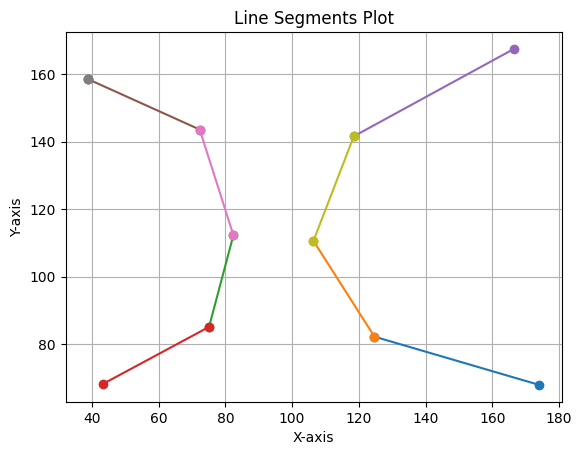

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Define the line segments
line_segments = remaining_sides

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each line segment
for (x1, y1), (x2, y2) in line_segments:
    ax.plot([x1, x2], [y1, y2], marker='o')

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Line Segments Plot')

# Display the plot
plt.grid(True)
plt.show()


((38.9, 158.5), (72.3, 143.6))
((72.3, 143.6), (82.4, 112.3))
((38.9, 158.5), (38.9, 158.5))


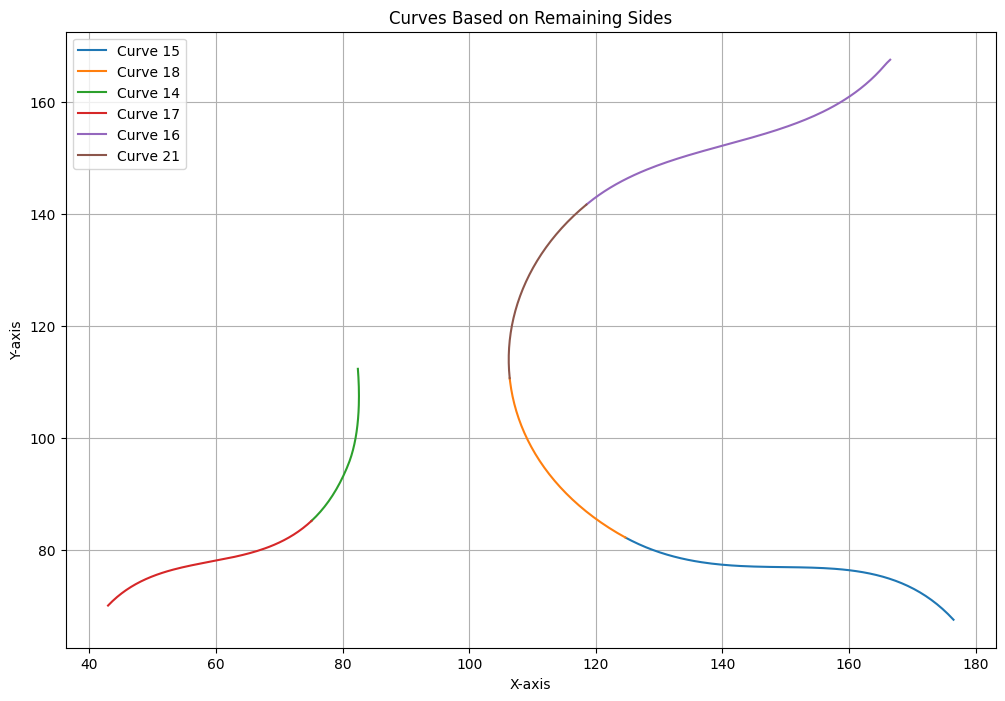

In [25]:

# print(valid_polygons)
# print(possible_circles)
# print(rejected_polygons)
# print(remaining_sides)
# print(merged_segments)


import matplotlib.pyplot as plt

def plot_curves_from_sides(curves, inverse_dict, remaining_sides):
    """Plot curves based on the remaining sides and their corresponding curves."""
    
    plt.figure(figsize=(12, 8))
    
    plotted_curves = set()
    
    for side in remaining_sides:
        # print(side)
        if side in inverse_dict:
            curve_num = inverse_dict[side]
            if curve_num not in plotted_curves:
                if curve_num in curves:
                    points = curves[curve_num]
                    x_values, y_values = zip(*points)
                    plt.plot(x_values, y_values, label=f'Curve {curve_num}')
                    plotted_curves.add(curve_num)
            else:
                print(curve_no)
        else:
            print(side)
    
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Curves Based on Remaining Sides')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
plot_curves_from_sides(curves, inverse_dict, remaining_sides)


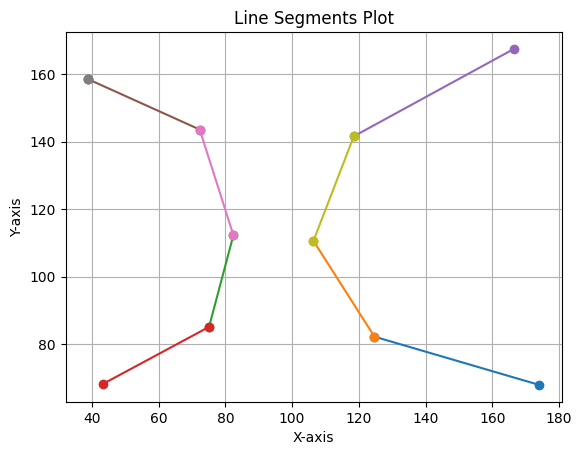

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Define the line segments
line_segments = remaining_sides

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each line segment
for (x1, y1), (x2, y2) in line_segments:
    ax.plot([x1, x2], [y1, y2], marker='o')

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Line Segments Plot')

# Display the plot
plt.grid(True)
plt.show()


[(array([107.79001527, 113.51507122]), np.float64(78.81889208471885), [(186.6, 114.7), (170.2, 163.0), (127.9, 191.5), (79.3, 189.3), (38.9, 158.5), (27.3, 112.4), (43.3, 68.2), (83.6, 38.5), (132.4, 39.2), (174.1, 67.9), (186.6, 114.7)])]
Side ((38.9, 158.5), (38.9, 158.5)) not found in inverse_dict.
{((225.2, 215.9), (9.9, 223.0)): 0, ((9.9, 223.0), (2.9, 7.7)): 1, ((2.9, 7.7), (218.1, 0.7)): 2, ((218.1, 0.7), (225.2, 215.9)): 3, ((186.6, 114.7), (170.2, 163.0)): 4, ((170.2, 163.0), (127.9, 191.5)): 5, ((127.9, 191.5), (79.3, 189.3)): 6, ((79.3, 189.3), (38.9, 158.5)): 7, ((38.9, 158.5), (27.3, 112.4)): 8, ((27.3, 112.4), (43.3, 68.2)): 9, ((43.3, 68.2), (83.6, 38.5)): 10, ((83.6, 38.5), (132.4, 39.2)): 11, ((132.4, 39.2), (174.1, 67.9)): 12, ((174.1, 67.9), (186.6, 114.7)): 13, ((75.1, 85.1), (82.4, 112.3)): 14, ((174.1, 67.9), (124.7, 82.2)): 15, ((118.5, 141.6), (166.5, 167.5)): 16, ((43.3, 68.2), (75.1, 85.1)): 17, ((124.7, 82.2), (106.4, 110.6)): 18, ((72.3, 143.6), (38.9, 158.5

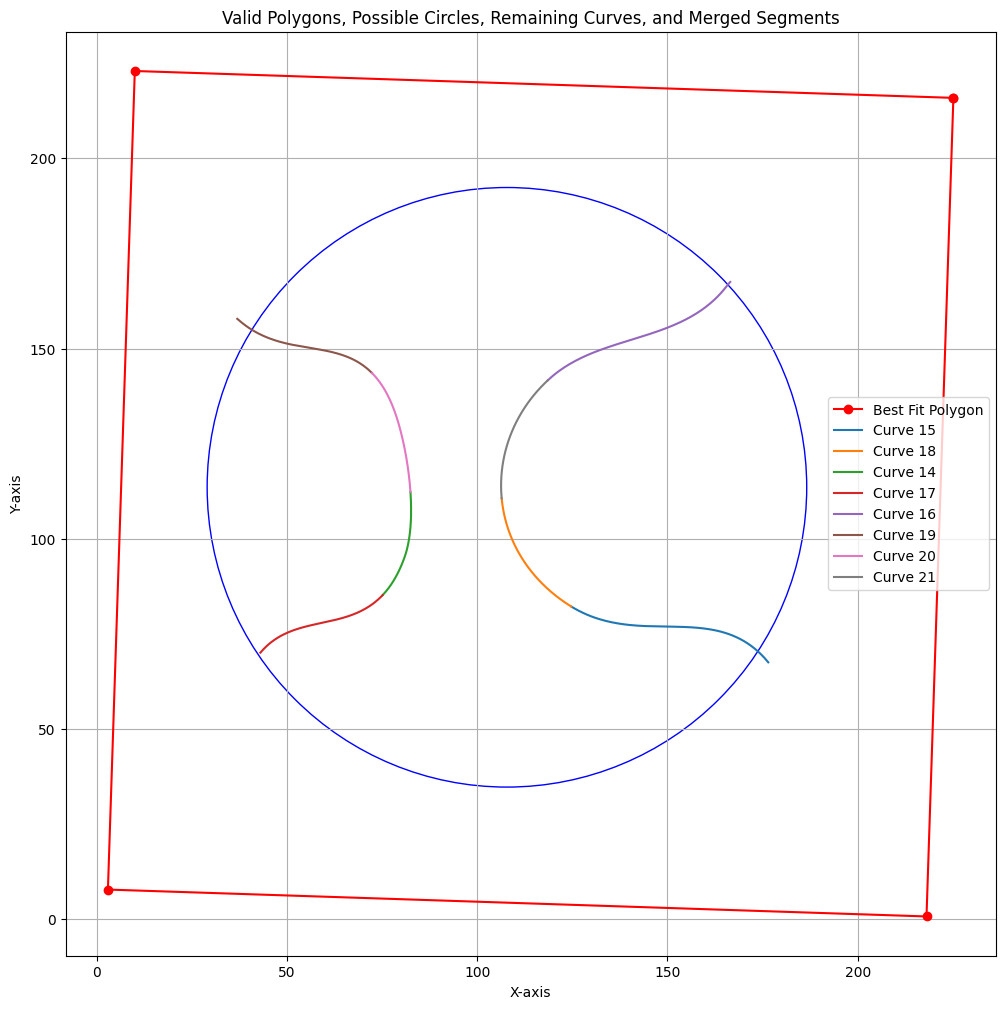

{((174.1, 67.9), (124.7, 82.2)), ((124.7, 82.2), (106.4, 110.6)), ((75.1, 85.1), (82.4, 112.3)), ((43.3, 68.2), (75.1, 85.1)), ((118.5, 141.6), (166.5, 167.5)), ((38.9, 158.5), (72.3, 143.6)), ((72.3, 143.6), (82.4, 112.3)), ((38.9, 158.5), (38.9, 158.5)), ((106.4, 110.6), (118.5, 141.6))}


In [27]:

import numpy as np
import matplotlib.pyplot as plt

def plot_all(valid_polygons, possible_circles, remaining_sides, curves, inverse_dict, merged_segments):
    plt.figure(figsize=(12, 12))

    # To collect all points for setting axis limits
    all_x = []
    all_y = []

    for best_fit_polygon, best_rotation_angle, best_radius in valid_polygons:
        all_x.extend(best_fit_polygon[:, 0])
        all_y.extend(best_fit_polygon[:, 1])
        plt.plot(np.append(best_fit_polygon[:, 0], best_fit_polygon[0, 0]), 
                 np.append(best_fit_polygon[:, 1], best_fit_polygon[0, 1]), 'ro-', label='Best Fit Polygon')

    print(possible_circles)
    for center, radius, circle_points in possible_circles:
        circle = plt.Circle(center, radius, color='b', fill=False)
        plt.gca().add_artist(circle)
        all_x.append(center[0] + radius)
        all_x.append(center[0] - radius)
        all_y.append(center[1] + radius)
        all_y.append(center[1] - radius)
        circle_points = np.array(circle_points)
        all_x.extend(circle_points[:, 0])
        all_y.extend(circle_points[:, 1])

    plotted_curves = set()
    for side in remaining_sides:
        # Try (a, b)
        if side in inverse_dict:
            curve_num = inverse_dict[side]
        # If (a, b) is not found, try (b, a)
        elif (side[1], side[0]) in inverse_dict:
            curve_num = inverse_dict[(side[1], side[0])]
        else:
            print(f"Side {side} not found in inverse_dict.")
            continue
        
        if curve_num not in plotted_curves:
            if curve_num in curves:
                points = curves[curve_num]
                # Unpack points into x_values and y_values
                x_values, y_values = zip(*points)
                all_x.extend(x_values)
                all_y.extend(y_values)
                plt.plot(x_values, y_values, label=f'Curve {curve_num}')
                plotted_curves.add(curve_num)

    print(inverse_dict)

        

    for segment in merged_segments:
        (x1, y1), (x2, y2) = segment
        all_x.extend([x1, x2])
        all_y.extend([y1, y2])
        plt.plot([x1, x2], [y1, y2], 'g-', label='Merged Segment')

    
    # plt.axis((500, 500 ,500, 500))

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Valid Polygons, Possible Circles, Remaining Curves, and Merged Segments')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensures the aspect ratio is equal to avoid distortion
    # plt.xlim(-100, 1500)
    # plt.ylim(-100, 1500)
    plt.show()


plot_all(valid_polygons, possible_circles, remaining_sides, curves, inverse_dict, filtered_merged_segments)
print(remaining_sides)